<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/CNN_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from torchvision import datasets
import torch
data_folder = '/Users/admin/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [18]:
tr_images = fmnist.data
tr_targets = fmnist.targets

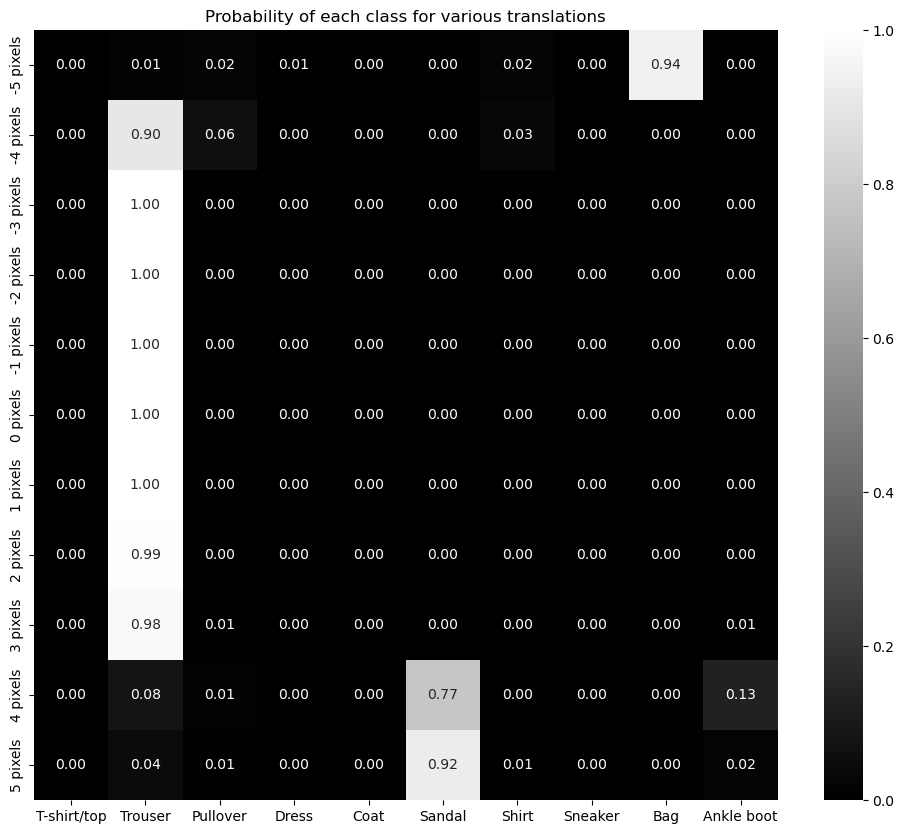

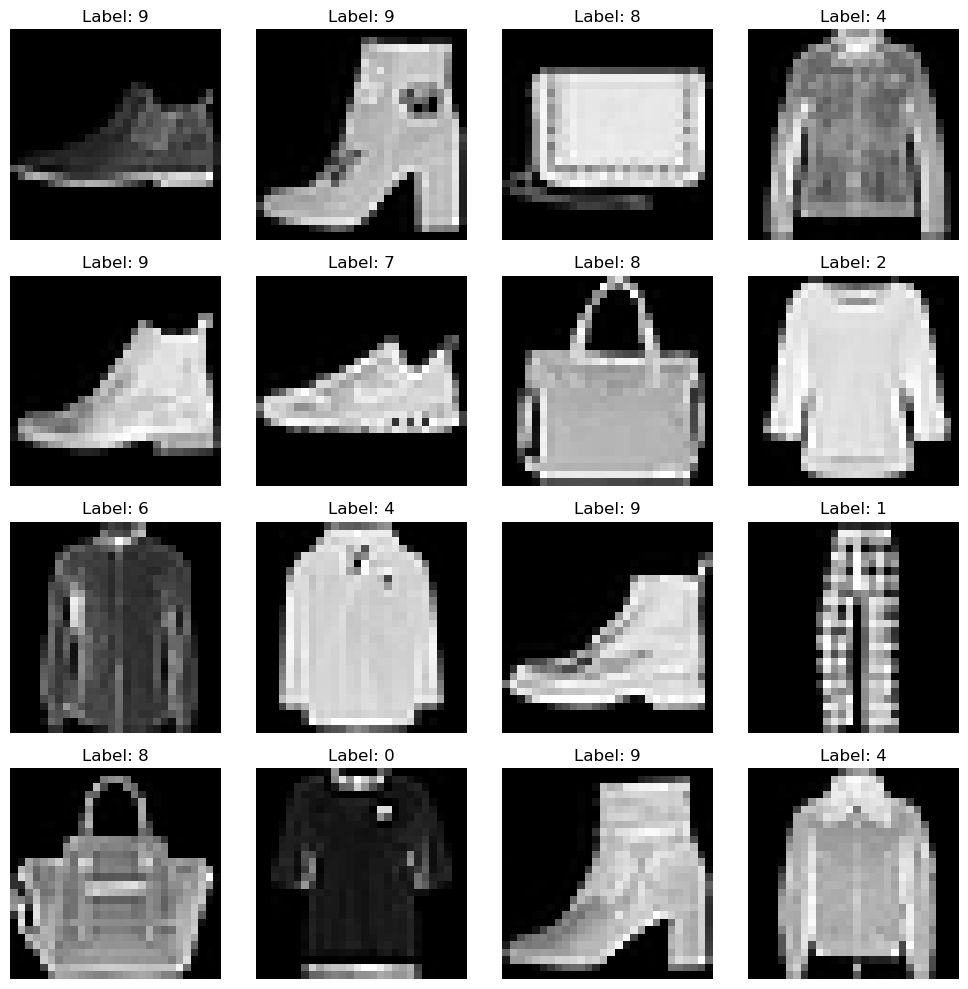

In [19]:
import random

import matplotlib.pyplot as plt

# Select 16 random indices
indices = random.sample(range(len(tr_images)), 16)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = tr_images[idx].numpy()
    label = tr_targets[idx].item()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [23]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [24]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [25]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [26]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [27]:
%pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

# model = nn.Sequential(
#     nn.Conv2d(1, 64, kernel_size=3),
#     nn.MaxPool2d(2),
#     nn.ReLU(),
#     nn.Conv2d(64, 128, kernel_size=3),
#     nn.MaxPool2d(2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Linear(3200, 256),
#     nn.ReLU(),
#     nn.Linear(256, 10)
# ).to(device)

# to find number of params in nn.Conv2d(Input_depth, Num_filters, kernel_size=K)
# Above nn.Conv2d() means Num_filters K * K filters will be moved across the input
# Each of the K * K filters will have a depth of input_depth
# I.e each input_depth * K * K set of points in the input will mapped to a single point as the convolution 
# Therefore #of params =  Input_depth * K * K * Num_filters + Num_filters bias parameters

# Conv2d: 1-1 [-1, 64, 26, 26] -> 26 * 26  because 3 * 3 kernel is moved across a 28 * 28 image        640 -> 64 filters * 10 (9 + 1 bias) params/per filter
# MaxPool2d: 1-2 [-1, 64, 13, 13] -> 13 * 13 because each 2 * 2 in the 26 * 26 out of Conv-2D is converted into a single value
# Conv2d: 1-4 [-1, 128, 11, 11] -> 11 * 11 because 3 * 3 kernel is moved across a 13 * 13 image.  #params = each of the 128 filters/input * 64 inputs * 10 params/filter

Note: you may need to restart the kernel to use updated packages.
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass siz

In [28]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


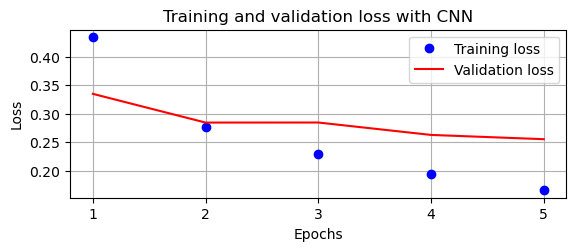

/var/folders/92/9tvlc6zs4cv30bn4v6cf4kl80000gn/T/ipykernel_19579/2406712320.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


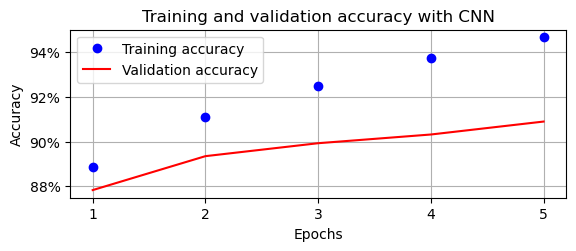

In [29]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

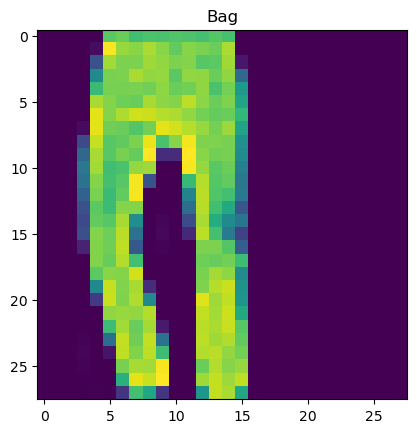

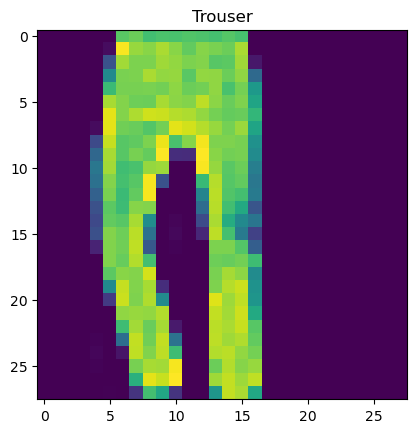

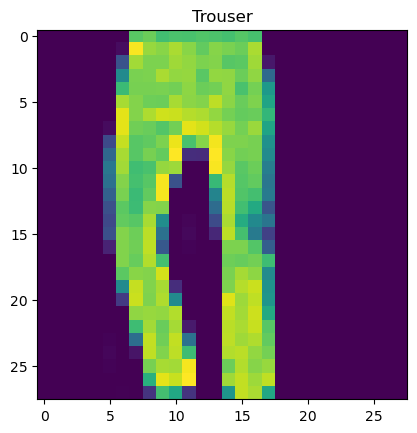

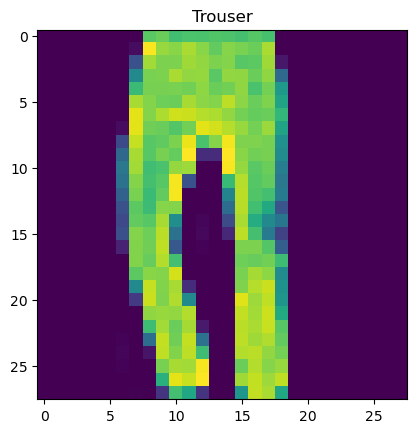

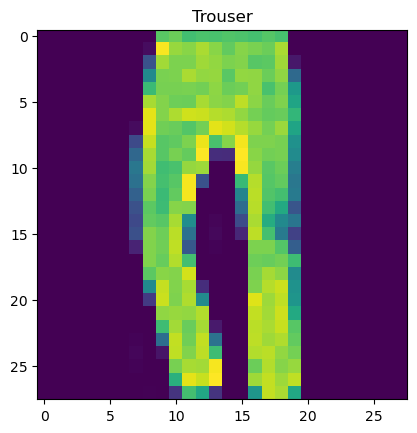

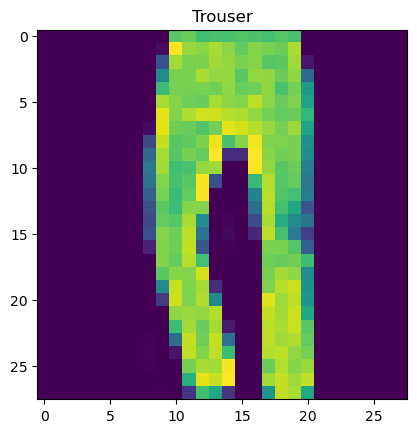

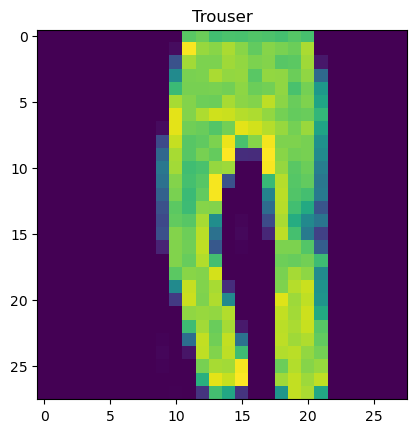

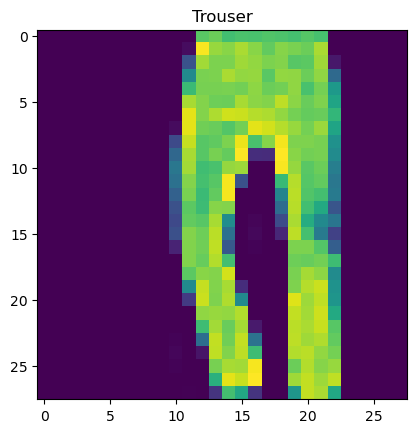

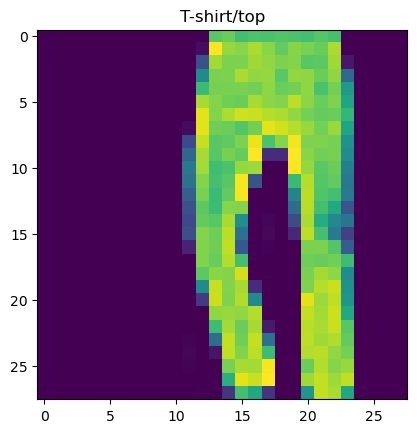

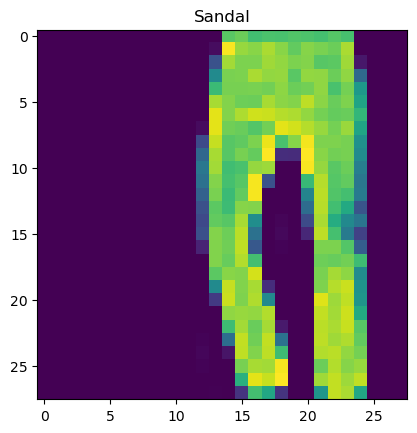

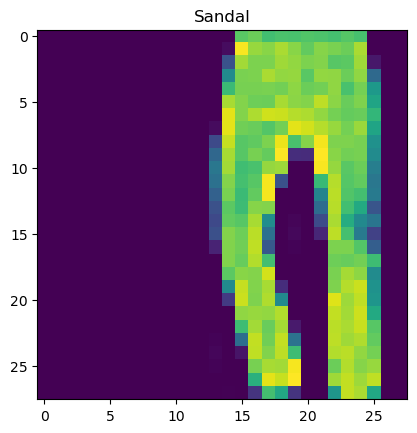

In [30]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [31]:
np.array(preds).shape

(11, 1, 10)

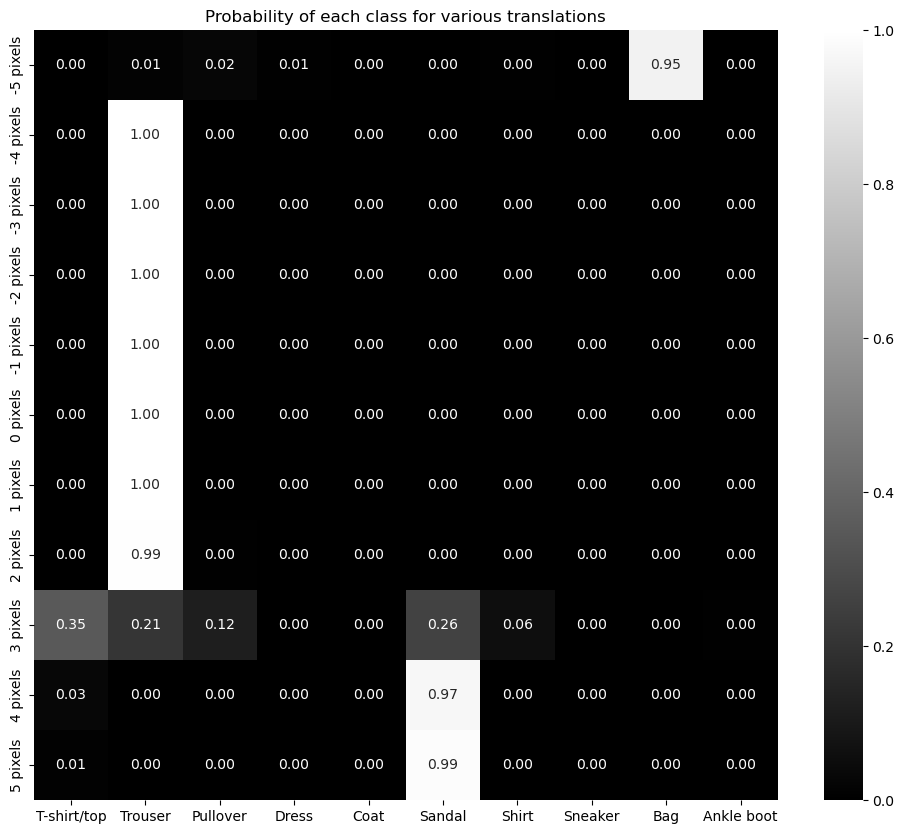

In [37]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.show()

In [ ]:
# def visualize_filter_layer(idx):
#   im, c = trn_dl.dataset[idx]
#   plt.figure(figsize=(10, 10))
#   plt.imshow(im[0].cpu())
#   plt.axis('off')  # Hide axes for better visualization
#   plt.show()
#   first_layer = nn.Sequential(*list(model.children())[:1])
#   intermediate_output = first_layer(im[None])[0].detach()
#   fig, ax = plt.subplots(8, 8, figsize=(10,10))
#   for ix, axis in enumerate(ax.flat):
#       axis.set_title('Filter: '+str(ix))
#       axis.imshow(intermediate_output[ix].cpu())
#   plt.tight_layout()
#   plt.show()

In [59]:
def get_model_until_layer(model, layer):
  first_layer = nn.Sequential(*list(model.children())[:layer])
  return first_layer

def visualize_cnn_filter_ouput(img_idx, layer_to_visualize):
  im, c = trn_dl.dataset[img_idx]
  plt.imshow(im[0].cpu())
  plt.show()
  first_layer = get_model_until_layer(model, layer_to_visualize)
  intermediate_output = first_layer(im[None])[0].detach()
  fig, ax = plt.subplots(8, 8, figsize=(10,10))
  for ix, axis in enumerate(ax.flat):
      axis.set_title('Filter: '+str(ix))
      axis.imshow(intermediate_output[ix].cpu())
  plt.tight_layout()
  plt.show()

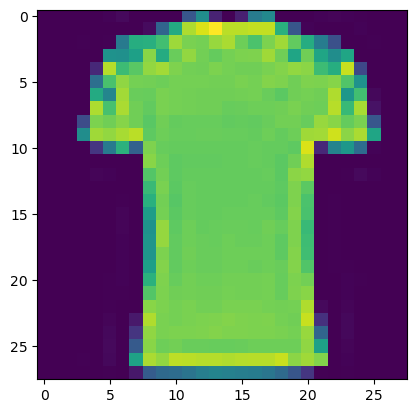

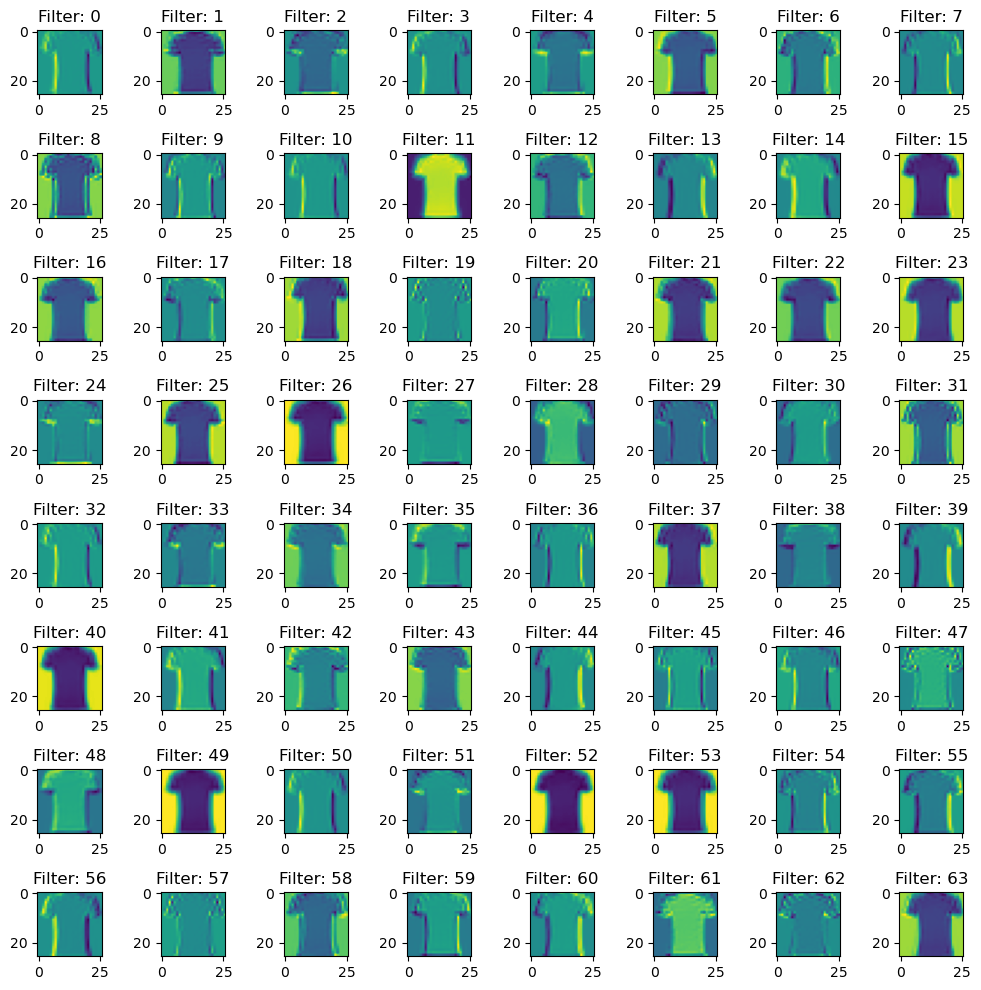

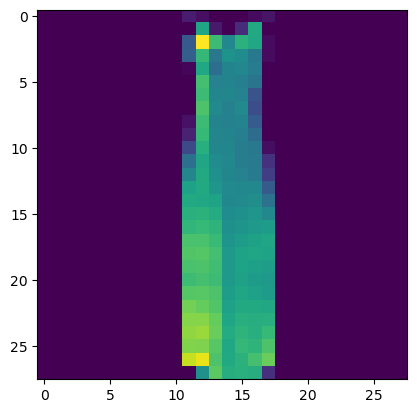

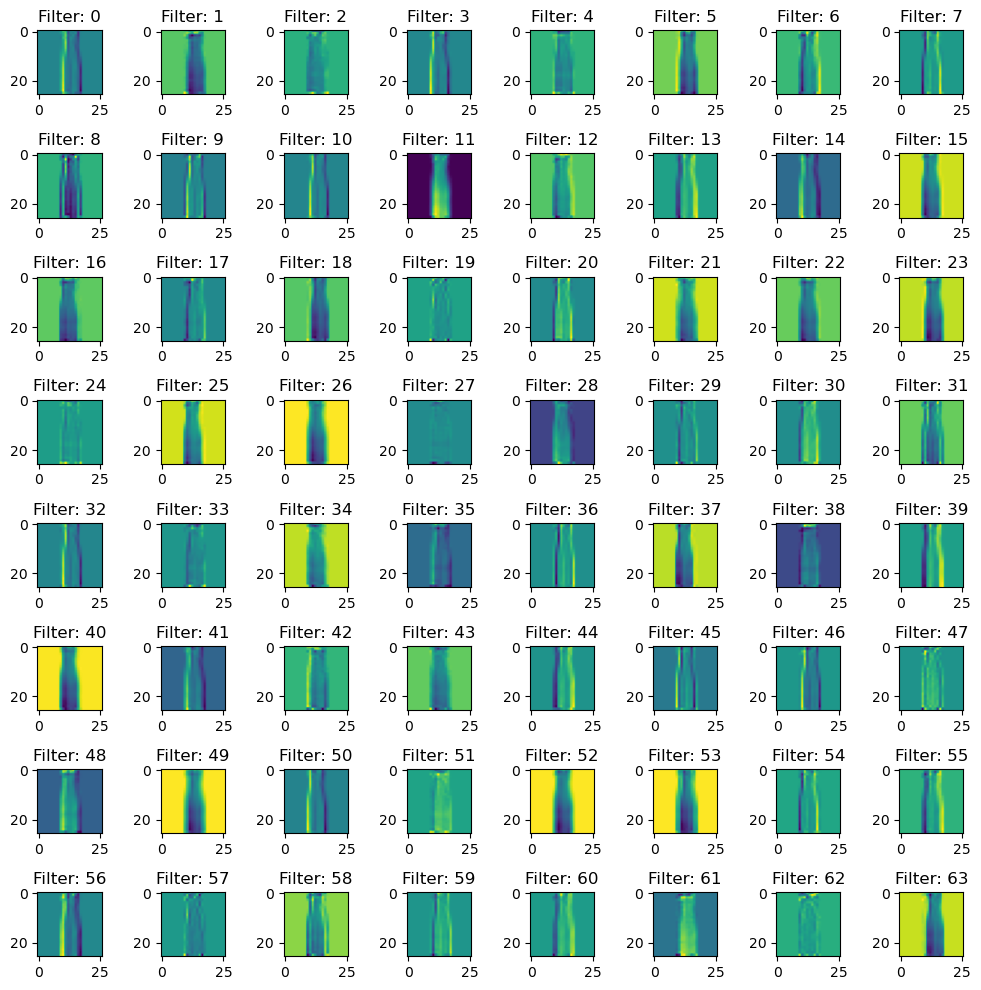

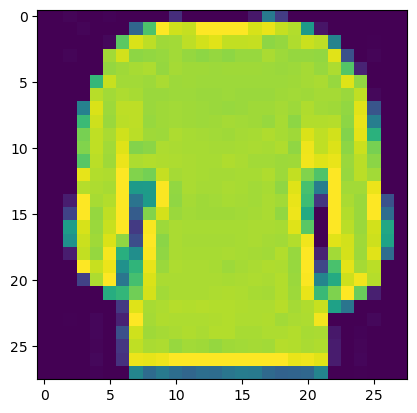

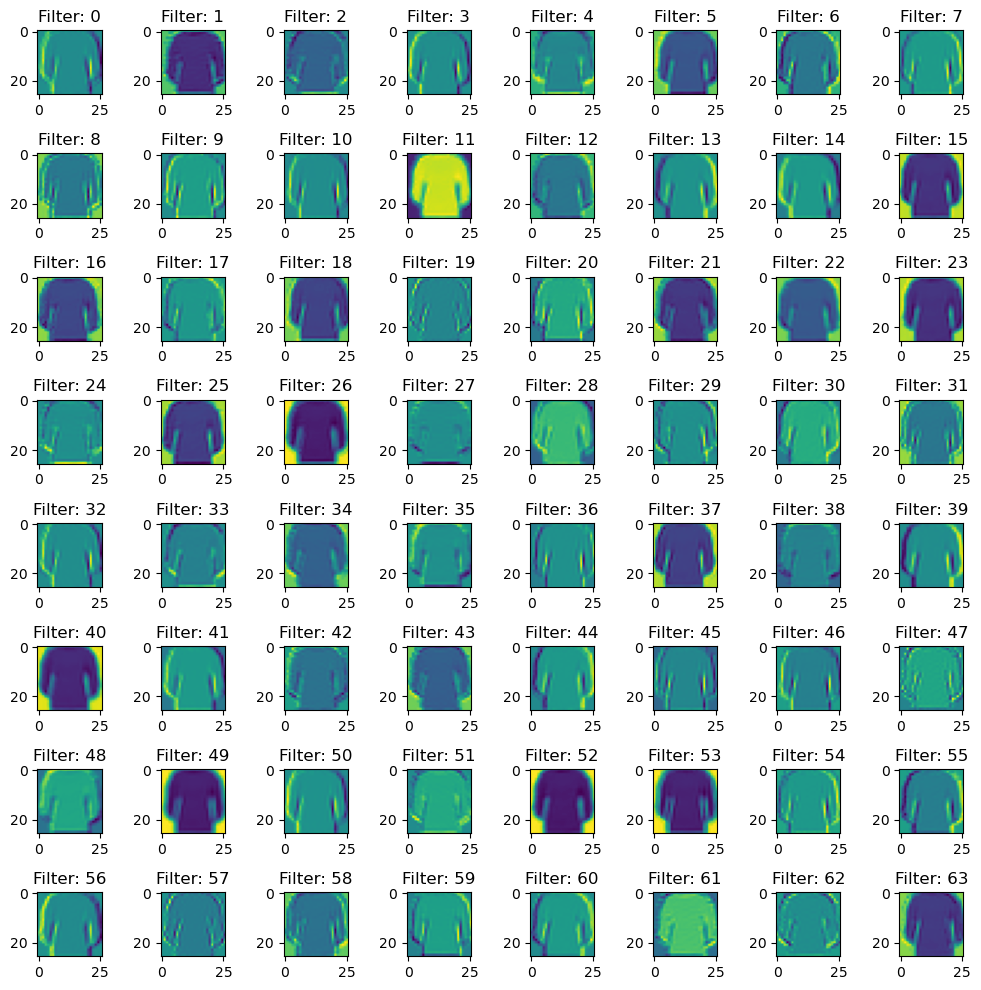

In [60]:
import random

# Assuming trn_dl is your DataLoader object
num_imgs_to_viz =3 
random_indices = random.sample(range(len(trn_dl.dataset)), num_imgs_to_viz)
for img_idx in random_indices:
  visualize_cnn_filter_ouput(img_idx, layer_to_visualize=1)

In [65]:
print(type(trn_dl))

<class 'torch.utils.data.dataloader.DataLoader'>


6000


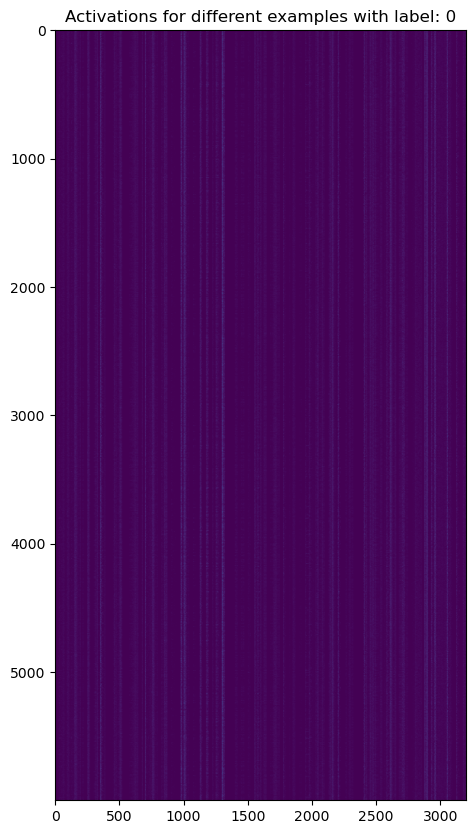

6000


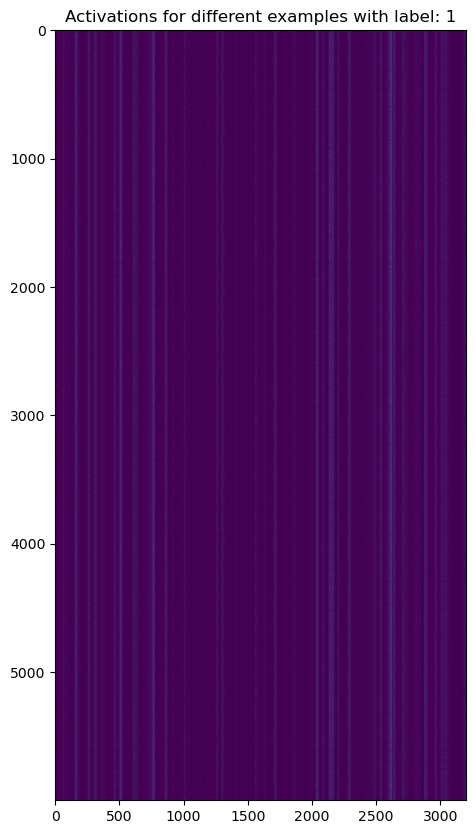

6000


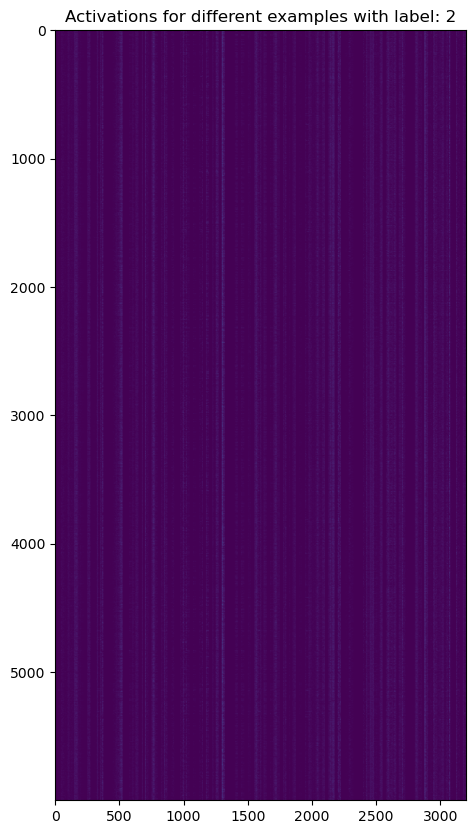

6000


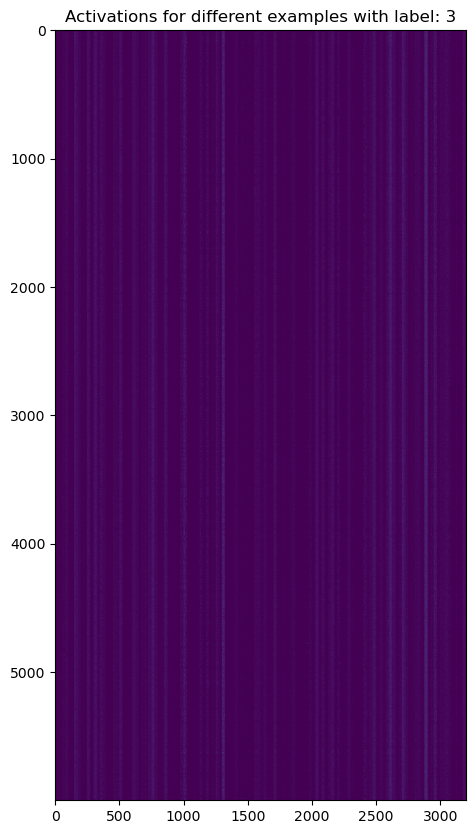

6000


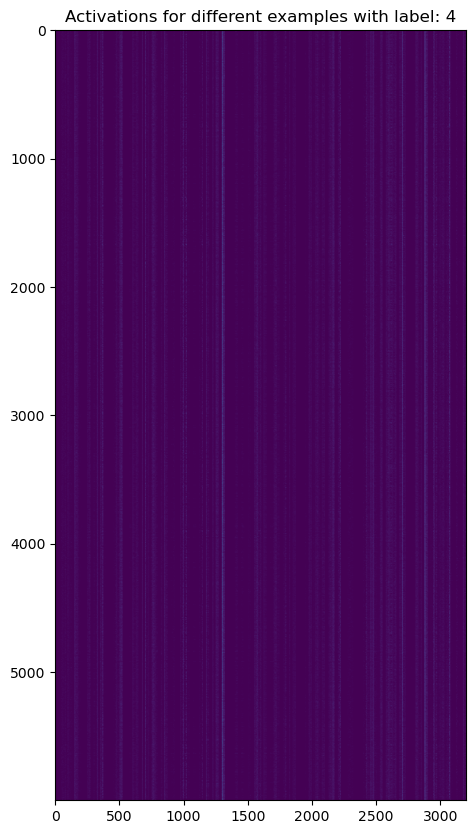

6000


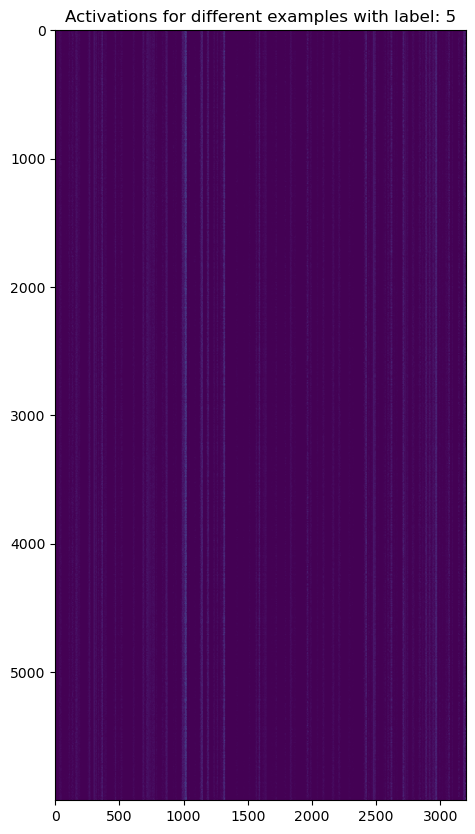

6000


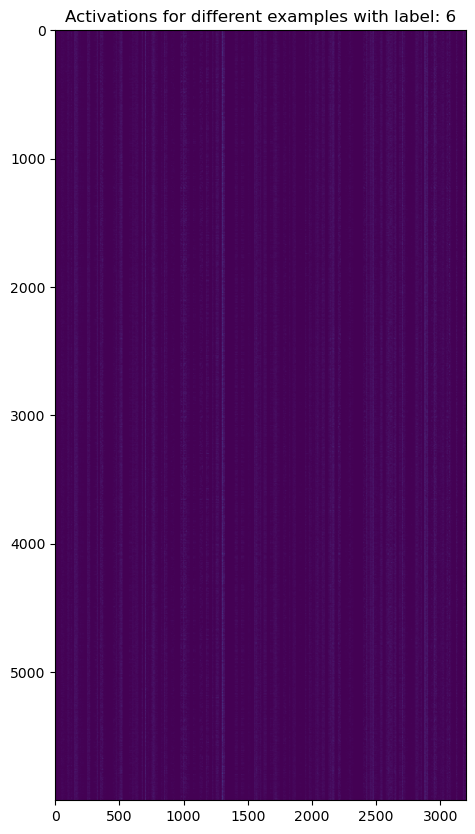

6000


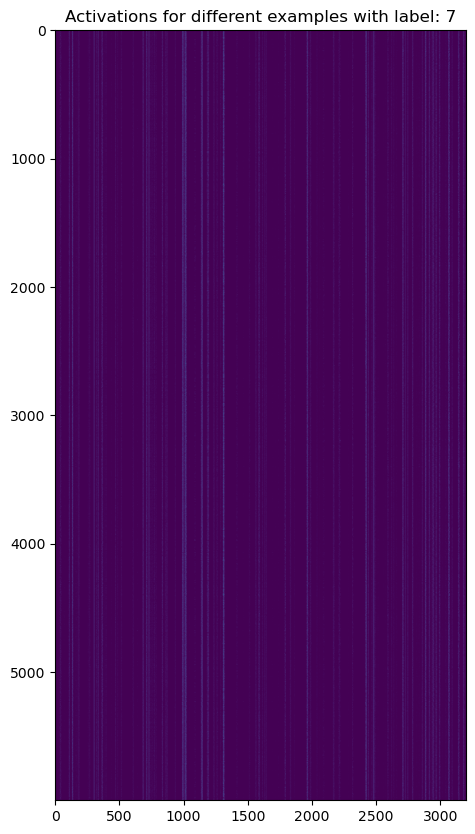

6000


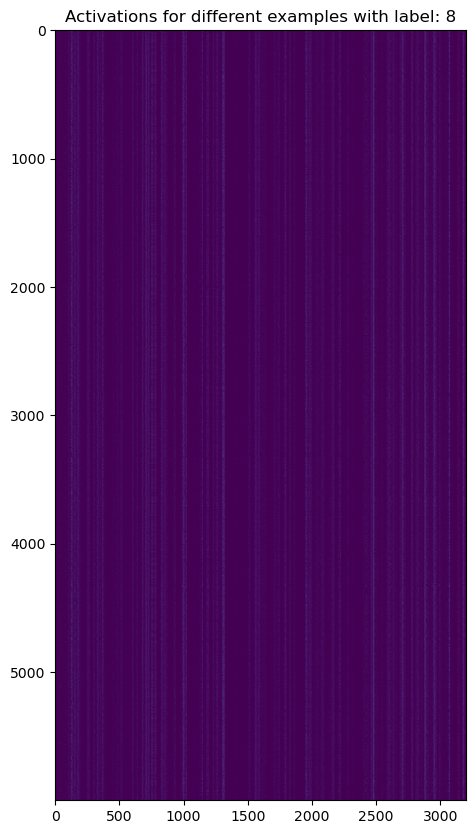

6000


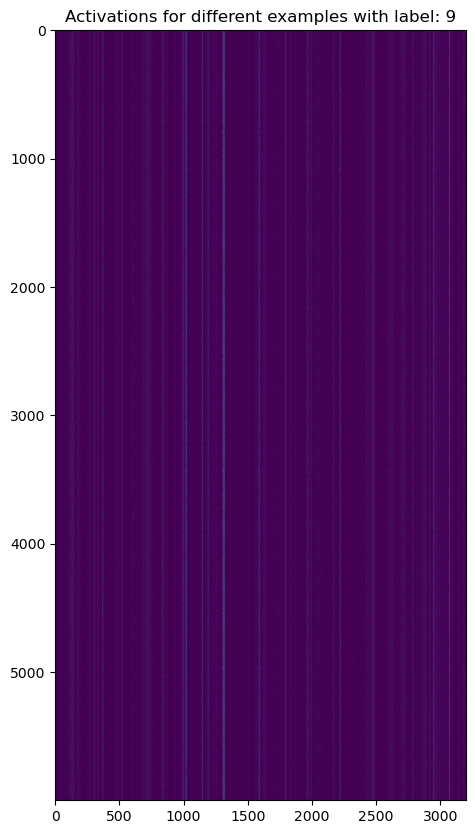

In [77]:
# Get boolean mask for target value 0
for target in tr_targets.unique():
    mask = tr_targets == target

    # Apply mask to get filtered images and targets
    filtered_images = tr_images[mask]
    filtered_targets = tr_targets[mask]
    print(len(filtered_targets))

    label0_dataset = FMNISTDataset(filtered_images, filtered_targets)     
    label0_dl = DataLoader(label0_dataset, batch_size=len(filtered_targets), shuffle=False)
    flatten_model = get_model_until_layer(model, 7)
    x, y = next(iter(label0_dl))
    outputs = flatten_model(x).detach()
    plt.figure(figsize=(100,10))
    plt.imshow(outputs.cpu())
    plt.title(f'Activations for different examples with label: {target}')
    plt.show()

# # Get the batch from DataLoader
# for batch in label0_dl:
# 	x, y = batch
# 	outputs = flatten_model(x).detach()
# 	plt.figure(figsize=(100,10))
# 	plt.imshow(outputs.cpu())
# 	plt.show()


In [ ]:
# prompt: can you create a 4 * 5 grid where each grid contains the a randomly selected image from tr_images along with corresponding label.  if there is a resource to map label to a description, please add that too.  Make sure each label is represented at least once

import matplotlib.pyplot as plt
import random

# Assuming tr_images, tr_targets are already defined from the previous code
# and you have a mapping for labels to descriptions (replace with your actual mapping)
label_descriptions = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Function to display a grid of images with labels and descriptions
def display_grid(images, labels, descriptions):
    fig, axes = plt.subplots(5, 4, figsize=(15, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}\n{descriptions[labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select random images, ensuring each label is represented at least once
selected_indices = []
selected_labels = []
labels_present = set()
while len(labels_present) < 10 :
    index = random.randint(0, len(tr_images) - 1)
    if index not in selected_indices:
        label = tr_targets[index].item()
        if label not in labels_present:
            labels_present.add(label)
        selected_indices.append(index)
        selected_labels.append(label)

while len(selected_indices) < 20:
  index = random.randint(0, len(tr_images) - 1)
  if index not in selected_indices:
    selected_indices.append(index)
    selected_labels.append(tr_targets[index].item())


# Display the grid
display_grid(tr_images[selected_indices], selected_labels, label_descriptions)
